In [329]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [330]:
data = pd.read_csv('fake_job_postings.csv')

In [331]:
data.head(10)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
5,6,Accounting Clerk,"US, MD,",NaN,NaN,NaN,Job OverviewApex is an environmental consultin...,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,0
6,7,Head of Content (m/f),"DE, BE, Berlin",ANDROIDPIT,20000-28000,"Founded in 2009, the Fonpit AG rose with its i...",Your Responsibilities: Manage the English-spea...,Your Know-How: ...,Your Benefits: Being part of a fast-growing co...,0,1,1,Full-time,Mid-Senior level,Master's Degree,Online Media,Management,0
7,8,Lead Guest Service Specialist,"US, CA, San Francisco",NaN,NaN,Airenvy’s mission is to provide lucrative yet ...,Who is Airenvy?Hey there! We are seasoned entr...,"Experience with CRM software, live chat, and p...",Competitive Pay. You'll be able to eat steak e...,0,1,1,NaN,NaN,NaN,NaN,NaN,0
8,9,HP BSM SME,"US, FL, Pensacola",NaN,NaN,Solutions3 is a woman-owned small business who...,Implementation/Configuration/Testing/Training ...,MUST BE A US CITIZEN.An active TS/SCI clearanc...,NaN,0,1,1,Full-time,Associate,NaN,Information Technology and Services,NaN,0
9,10,Customer Service Associate - Part Time,"US, AZ, Phoenix",NaN,NaN,"Novitex Enterprise Solutions, formerly Pitney ...",The Customer Service Associate will be based i...,Minimum Requirements:Minimum of 6 months custo...,NaN,0,1,0,Part-time,Entry level,High School or equivalent,Financial Services,Customer Service,0


In [332]:
data_array = np.array(data)

In [297]:
# Вектор весов признаков (для начала чисто интуитивный)

weights = np.array([
    0,     # 0 идентификатор вакансии -- он есть у всех
    0.1,   # 1 название вакансии
    0.3,   # 2 географическое место работы
    0.1,   # 3 отдел работы
    0.2,   # 4 диапазон запрлат
    0.3,   # 5 краткое описание компании
    0.3,   # 6 подробное описание вакансии
    0.3,   # 7 требование к соискателю
    0.05,   # 8 предлагаемые льготы
    0.05,   # 9 предлагает дистанционку или нет
    0.3,   # 10 есть ли лого
    0.15,   # 11 есть ли список вопросов к соискателю
    0.1,   # 12 тип вакансии: полный рабочий день/контракт
    0.3,   # 13 требуемый опыт: руководить, стажёр и.т.д.
    0.1,   # 14 требуемое образование: доктор наук, бакалавр и т.д.
    0.3,   # 15 в какой области предстоит работать: IT, медицина и т.д.
    0.3,   # 16 область работы: маркетинг/разработка и т.д.
    0      # 17 подделка или нет. Целевая переменная.
]) 


In [306]:
# функция, определяющая, так сказать, насколько данный аттрибут соответствует фейку.

def handle_attribute(attr, type_of_attr):
    
    # Те признаки, у которых нас волнует только наличие или отсутствие
    if (type_of_attr in [0, 1, 3, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]):
        if (pd.isnull(attr)):
            return 1
        else:
            return 0
        
    # Локация. Хотим, чтобы она, во-первых, была, а во вторых была примерно по формату (AA, AA, name)
    if (type_of_attr == 2):
        if (pd.isnull(attr)):
            return 1
        if (len(attr.split(',')) == 3 and np.all([i != '' and i !=' ' for i in attr.split(',')])):
            return 0
        else:
            return 1
         
    # Не хотим слишком большие зарплаты и слишком маленькие, но NaN -- это норм
    if (type_of_attr == 4):
        if (pd.isnull(attr)):
            return 0
        
        try:
            salary_range = [int(i) for i in attr.split('-')]
        except Exception:
            return 1
            
        if (np.any([i < 5000 or i > 1000000 for i in salary_range])):
            return 1
        else:
            return 0
        
    # Не хотим слишком коротких текстов и всякой фигни
    if (type_of_attr == 6 or type_of_attr == 5):
        if (pd.isnull(attr)):
            return 1
        
        if (len(attr) < 500 and type_of_attr == 6):
            return 1
        if (len(attr) < 100 and type_of_attr == 5):
            return 1
            
        # Тут простор для творчества, но пока ограничимся первым, что я с первого взглляда
        if (attr.count('\xa0') > 50):
            return 2
        return 0

In [307]:
# Теперь сделаем теперь заменим значение каждой ячейки на её метрику
data_array_numbers = np.copy(data_array)
for i in range(len(data_array_numbers)):
    for j in range(18):
        data_array_numbers[i][j] = handle_attribute(data_array_numbers[i][j], j)

In [308]:
# теперь для каждого посчитаем степень фейковости, просто скалярно перемножив на веса

fake_degree = np.zeros(len(data_array_numbers))
for i in range(len(fake_degree)):
    fake_degree[i] = np.dot(data_array_numbers[i], weights)

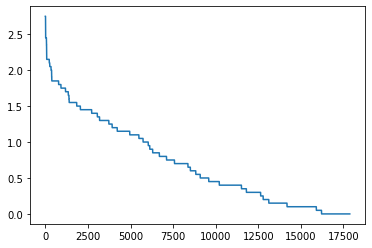

In [309]:
# отсортируем по убыванию и посмотрим на график
sorted_result = sorted(fake_degree)[::-1]
x = np.arange(len(sorted_result))
plt.plot(x, sorted_result)

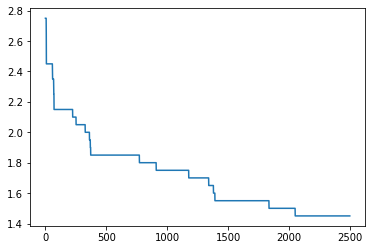

In [312]:
plt.plot(x[:2500:], sorted_result[:2500:])

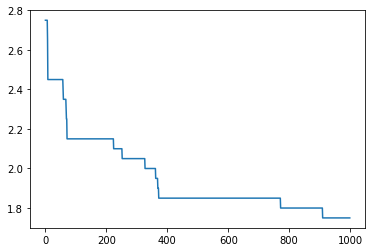

In [313]:
plt.plot(x[:1000:], sorted_result[:1000:])

Остановимся на скачке около 800

In [317]:
sorted_result[760:780:]

[1.85,
 1.85,
 1.85,
 1.85,
 1.85,
 1.85,
 1.85,
 1.85,
 1.85,
 1.85,
 1.85,
 1.85,
 1.8,
 1.8,
 1.8,
 1.8,
 1.8,
 1.8,
 1.8,
 1.8]

In [320]:
bound = 1.8

In [326]:
# Окончательно, заполним последнюю колонку
for i in range (len(fake_degree)):
    if (fake_degree[i] > bound):
        data['fraudulent'][i] = 1

/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [328]:
data.head(10)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,1
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
5,6,Accounting Clerk,"US, MD,",NaN,NaN,NaN,Job OverviewApex is an environmental consultin...,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,1
6,7,Head of Content (m/f),"DE, BE, Berlin",ANDROIDPIT,20000-28000,"Founded in 2009, the Fonpit AG rose with its i...",Your Responsibilities: Manage the English-spea...,Your Know-How: ...,Your Benefits: Being part of a fast-growing co...,0,1,1,Full-time,Mid-Senior level,Master's Degree,Online Media,Management,0
7,8,Lead Guest Service Specialist,"US, CA, San Francisco",NaN,NaN,Airenvy’s mission is to provide lucrative yet ...,Who is Airenvy?Hey there! We are seasoned entr...,"Experience with CRM software, live chat, and p...",Competitive Pay. You'll be able to eat steak e...,0,1,1,NaN,NaN,NaN,NaN,NaN,0
8,9,HP BSM SME,"US, FL, Pensacola",NaN,NaN,Solutions3 is a woman-owned small business who...,Implementation/Configuration/Testing/Training ...,MUST BE A US CITIZEN.An active TS/SCI clearanc...,NaN,0,1,1,Full-time,Associate,NaN,Information Technology and Services,NaN,0
9,10,Customer Service Associate - Part Time,"US, AZ, Phoenix",NaN,NaN,"Novitex Enterprise Solutions, formerly Pitney ...",The Customer Service Associate will be based i...,Minimum Requirements:Minimum of 6 months custo...,NaN,0,1,0,Part-time,Entry level,High School or equivalent,Financial Services,Customer Service,0
